In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, sosfilt, iirnotch, tf2sos
import pandas as pd
from datetime import datetime
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from tkinter.simpledialog import askinteger
import os

In [2]:
# Butterworth Bandpass Filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos

# Notch Filter
def notch_filter(freq, fs, Q=30):
    nyq = 0.5 * fs
    w0 = freq / nyq
    b,a = iirnotch(w0, Q)
    sos = tf2sos(b, a)
    return sos

# Apply Filters
def apply_filters(data, fs):
    lowcut = 5.0
    highcut = 50.0
    filtered_data = data

    # Apply bandpass filter
    sos_bandpass = butter_bandpass(lowcut, highcut, fs)
    filtered_data = sosfilt(sos_bandpass, filtered_data)

    # Apply notch filters at 50Hz and 60Hz
    for freq in [50, 60]:
        sos_notch = notch_filter(freq, fs)
        filtered_data = sosfilt(sos_notch, filtered_data)

    return filtered_data

# Plotting function
def plot_data(times, data, title):
    plt.style.use("dark_background")
    plt.figure(figsize=(12, 6))
    plt.ylim(-2,2)
    plt.plot(times, data, label=title)
    plt.xlabel('Time')
    plt.ylabel('Voltage ($\mu$V)')
    plt.title(title)
    plt.show()

# Function to select the file
def select_file():
    root = Tk()
    root.withdraw()  # Suppress the Tkinter root window
    filename = askopenfilename()  # Show an "Open" dialog box and return the path to the selected file
    root.destroy()  # Close the Tkinter root window
    return filename


def query_channel():
    root = Tk()
    root.withdraw()  # Suppress the Tkinter root window
    channel = askinteger("Input", "Choose a channel (0-7):")
    root.destroy()
    return channel


In [3]:
def filter_and_select(filename):
    df = pd.read_csv(filename, skiprows=4)
    starttime = pd.to_datetime(df[' Timestamp (Formatted)'].iloc[0])
    df['Elapsed time (s)'] = df[' Timestamp (Formatted)'].apply(lambda x: (pd.to_datetime(x) - starttime).total_seconds())
    times = df['Elapsed time (s)']

    # Display static graphs before querying the user
    for i in range(1, 9):
        channel_data = df.iloc[:, i].values
        filtered_data = apply_filters(channel_data, fs)
        plot_data(times, filtered_data, f'EXG Channel {i-1} Filtered')

    chosen_channel = query_channel()
    if chosen_channel is None or chosen_channel < 0 or chosen_channel > 7:
        print("Invalid channel selection.")
        return

    channel_data = df.iloc[:, chosen_channel + 1].values
    filtered_data = apply_filters(channel_data, fs)
    time_data = times.values
    return time_data, filtered_data
    



In [4]:
fs = 250  # Sampling frequency
filename = select_file()
if not filename:
    print("No file selected.")

filtered_filename = f"{filename[:-4]}.csv"
already_filtered = os.path.isfile(filtered_filename)



In [5]:
already_filtered

True

In [6]:
plotting_ratio = 5
frame_rate = 60
ms_interval = 1000/frame_rate
s_interval = ms_interval/1000

if already_filtered:
    filtered_df = pd.read_csv(filtered_filename)
    interped_time, interped_emg = filtered_df['Time (s)'].to_numpy(), filtered_df['Filtered EMG Response'].to_numpy()
else:
    time_data, filtered_data = filter_and_select(filename)
    interped_time = np.arange(time_data[0], time_data[-1], s_interval)
    interped_emg = np.interp(interped_time, time_data, filtered_data)
    filtered_df = pd.DataFrame({'Time (s)' : interped_time, 'Filtered EMG Response': interped_emg})
    filtered_df.to_csv(filtered_filename)



In [7]:
interped_time


array([0.00000000e+00, 1.66666667e-02, 3.33333333e-02, ...,
       1.09933333e+02, 1.09950000e+02, 1.09966667e+02])

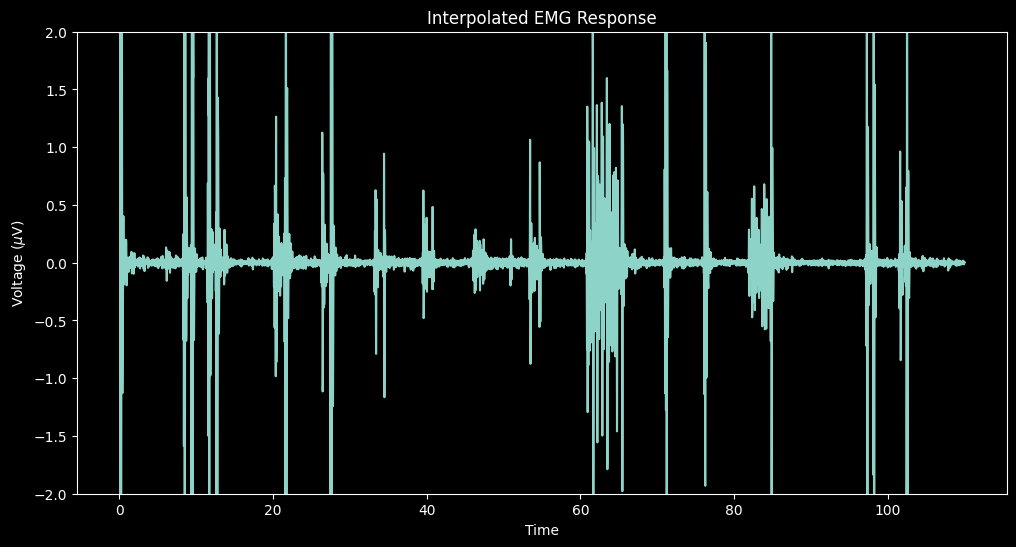

In [8]:
plot_data(interped_time, interped_emg/1000,
          f'Interpolated EMG Response')

In [9]:
from matplotlib.animation import FuncAnimation
from functools import partial

In [10]:
def animate(i, times, fs, data, line, window=5):
    print(i)
    start = times[i*plotting_ratio]
    end = start + window
    if end > times[-1]:
        end = times[-1]
        start = end - window
    plt.xlim(start, end)
    plt.ylim(-1, 1)
    line.set_data(times, data)
    return line,


In [11]:
def create_animation():

    #fig, ax = plt.subplots(figsize=(4.5,3), dpi=200)
    fig = plt.figure(figsize=(4.5,3), dpi=300)
    ax = fig.add_axes([0.18, 0.1, 0.7, 0.75]) 
    line, = ax.plot([], [], lw=2)
    #ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (V)', fontsize=20)
    ax.set_xlabel('5-second window', fontsize=20)
    plt.locator_params(axis='y', nbins=3)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    #ax.set_title(f'EMG Activity ($\mu$V)', fontsize=22)
    plt.tick_params(axis='y', labelsize=20)

    # Adjusting the frames and interval for real-time playback
    # Adjust if necessary for smoother playback
    interval = ms_interval*plotting_ratio  # milliseconds per frame

    def init():
        ax.set_xlim(0, 5)
        ax.set_ylim(-1, 1)
        return line,

    frames=len(interped_time)//plotting_ratio
    ani = FuncAnimation(fig, partial(animate, times=interped_time, fs=fs, data=interped_emg/1000, line=line, window=5), init_func=init, frames=frames,
                        blit=True, interval=interval, repeat=False)
    
    # Save animation
    video_dir = os.path.join(os.path.dirname(filename), 'emg_animations')
    os.makedirs(video_dir, exist_ok=True)
    video_filename = os.path.splitext(os.path.basename(filename))[0] + f'.mp4'
    video_path = os.path.join(video_dir, video_filename)
    ani.save(video_path, writer='ffmpeg', fps=frame_rate//plotting_ratio)

    print(f"Animation saved to {video_path}")



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

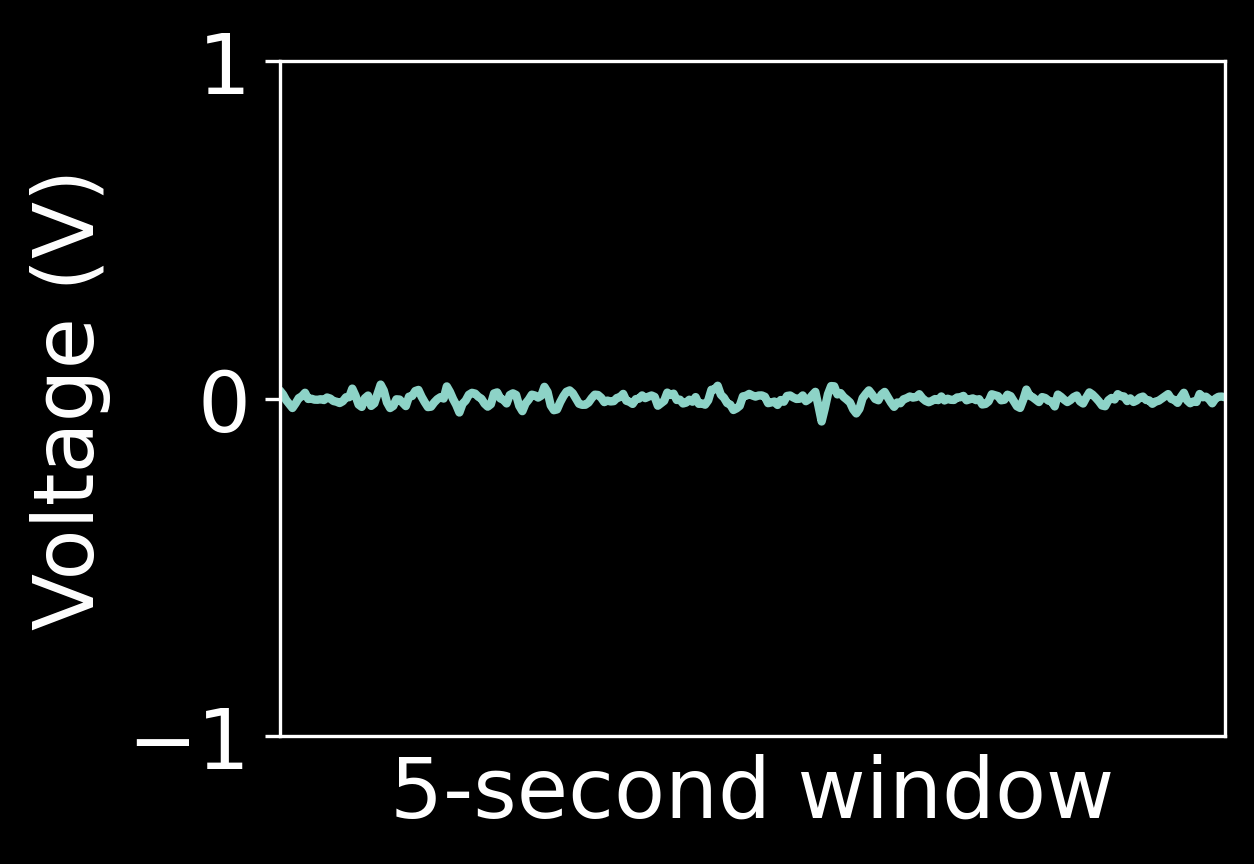

In [12]:
create_animation()

In [13]:
#flexor_1, extensor_2, extensor_3